# Self-Correction Evaluation

In this notebook, we analyze the results of all dataset–model pairs from the self-refinement evaluation experiment. The analysis focuses on model performance before and after hint injection, the role of the `max_tokens` parameter used during generation, and comparisons among model families.

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from plots import plot_by_dataset, plot_aggregated_metric_by_dataset

In [3]:
# Load data
metrics = pd.read_csv("results/correction_metrics.csv")
token_counts = pd.read_csv("results/token_counts.csv")

In [4]:
MODELS_NON_REASONING=[
  "google/gemma-2-2b-it",
  "meta-llama/Meta-Llama-3.1-8B-Instruct",
  "microsoft/Phi-4-mini-instruct",
  "Qwen/Qwen2.5-Math-1.5B",
  "Qwen/Qwen2.5-Math-7B" # not sure keep or not
]

MODELS_REASONING=[
  "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B",
  "deepseek-ai/DeepSeek-R1-0528-Qwen3-8B",
  "deepseek-ai/DeepSeek-R1-Distill-Llama-8B",
  "microsoft/Phi-4-mini-reasoning"
]

In [5]:
# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# Model categorization
def categorize_model(model_name):
    reasoning_keywords = [
        "DeepSeek-R1",
        "Phi-4-mini-reasoning"
    ]
    for keyword in reasoning_keywords:
        if keyword in model_name:
            return "Reasoning"
    return "Non-Reasoning"

# Simplify model names for plots
def simplify_model_name(model_name):
    if "/" in model_name:
        return model_name.split("/")[-1]
    return model_name

# Apply to metrics
metrics["model_category"] = metrics["model"].apply(categorize_model)
metrics["model_short"] = metrics["model"].apply(simplify_model_name)

# Apply to token counts
token_counts["model_category"] = token_counts["model"].apply(categorize_model)
token_counts["model_short"] = token_counts["model"].apply(simplify_model_name)


## I. Effect of Maximum Token Budget
This section analyzes how increasing the maximum number of tokens affects model performance across different datasets.

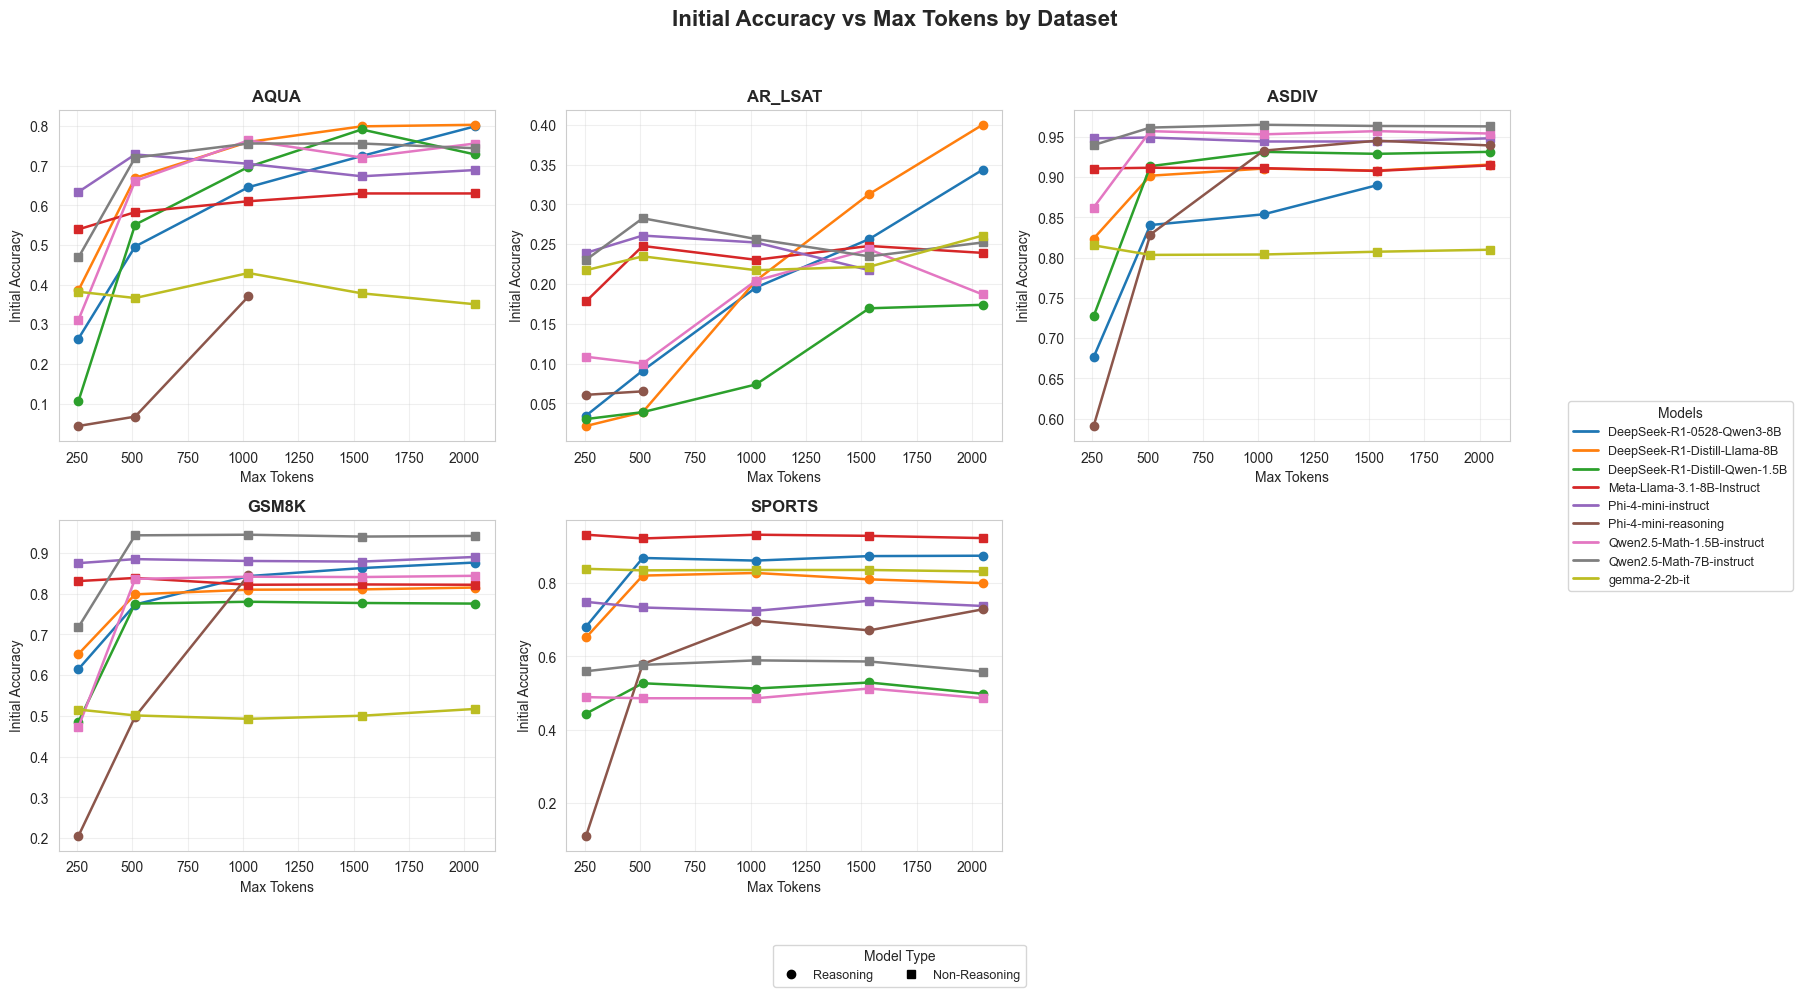

In [6]:
# 1. Initial Accuracy
plot_by_dataset(
    metrics, "initial_accuracy", "Initial Accuracy",
    "Initial Accuracy vs Max Tokens by Dataset"
)

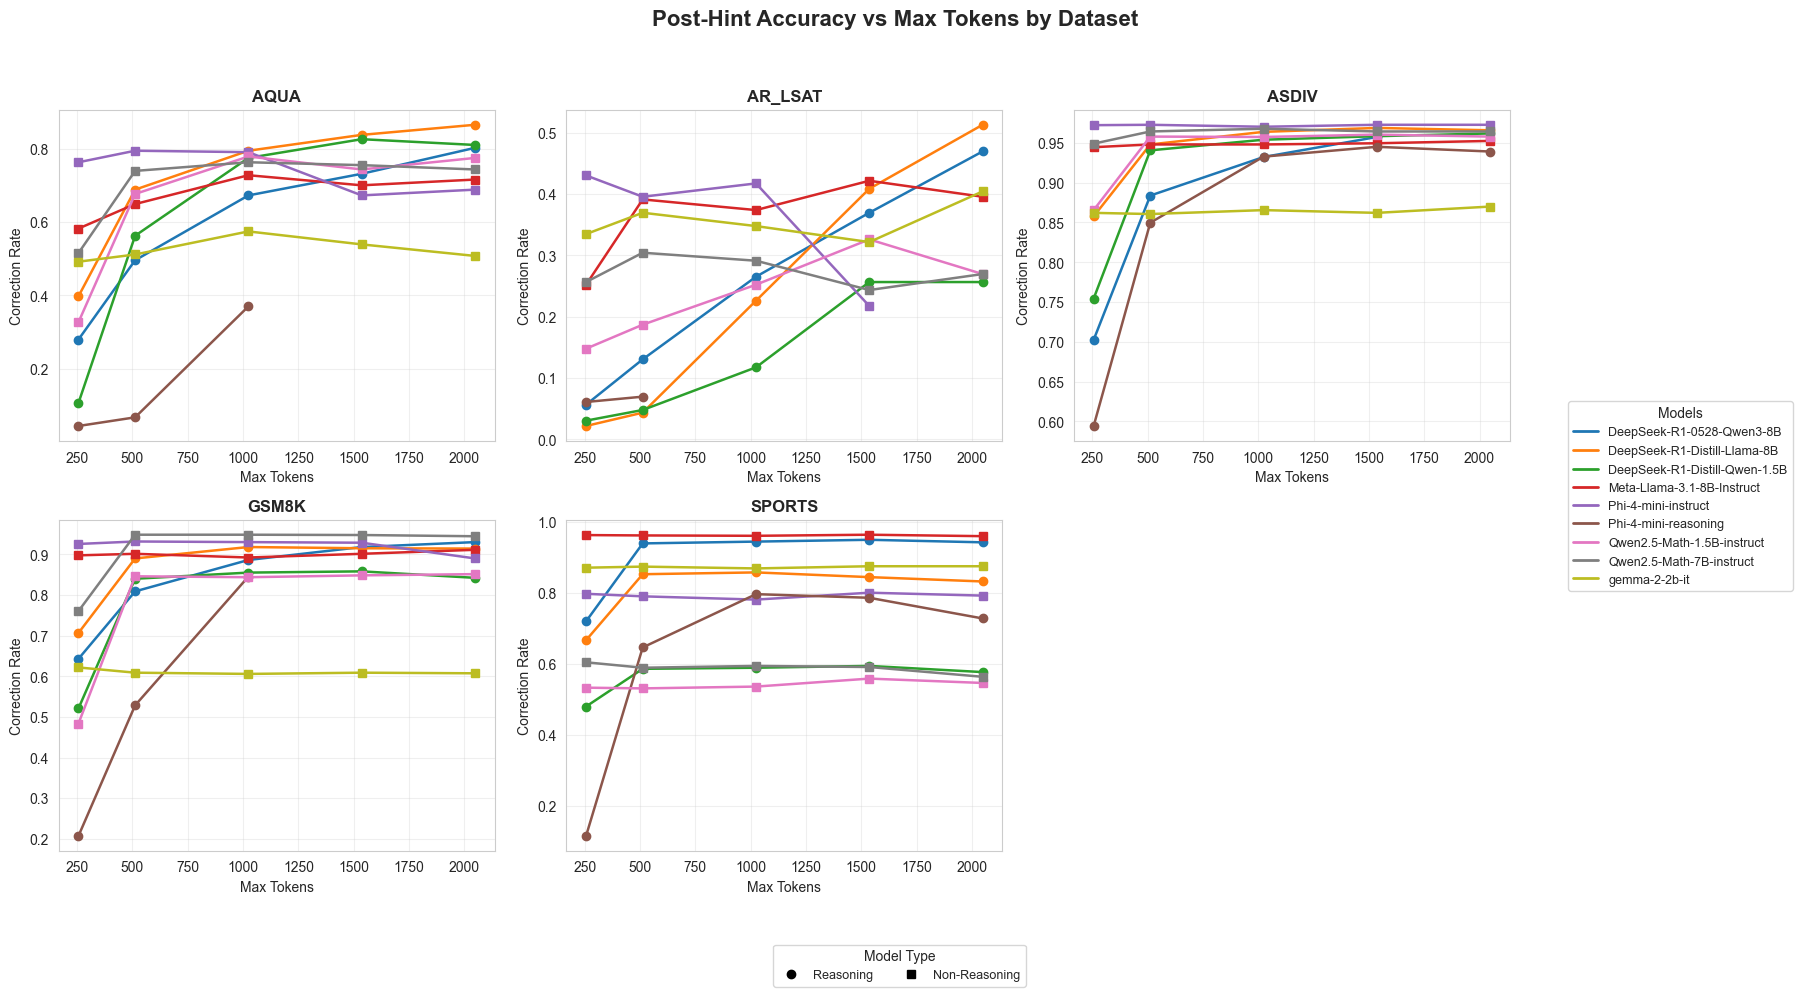

In [7]:
# Per-dataset y-scale (more detail inside each dataset)
plot_by_dataset(
    metrics, "posthint_accuracy", "Correction Rate",
    "Post-Hint Accuracy vs Max Tokens by Dataset"
)

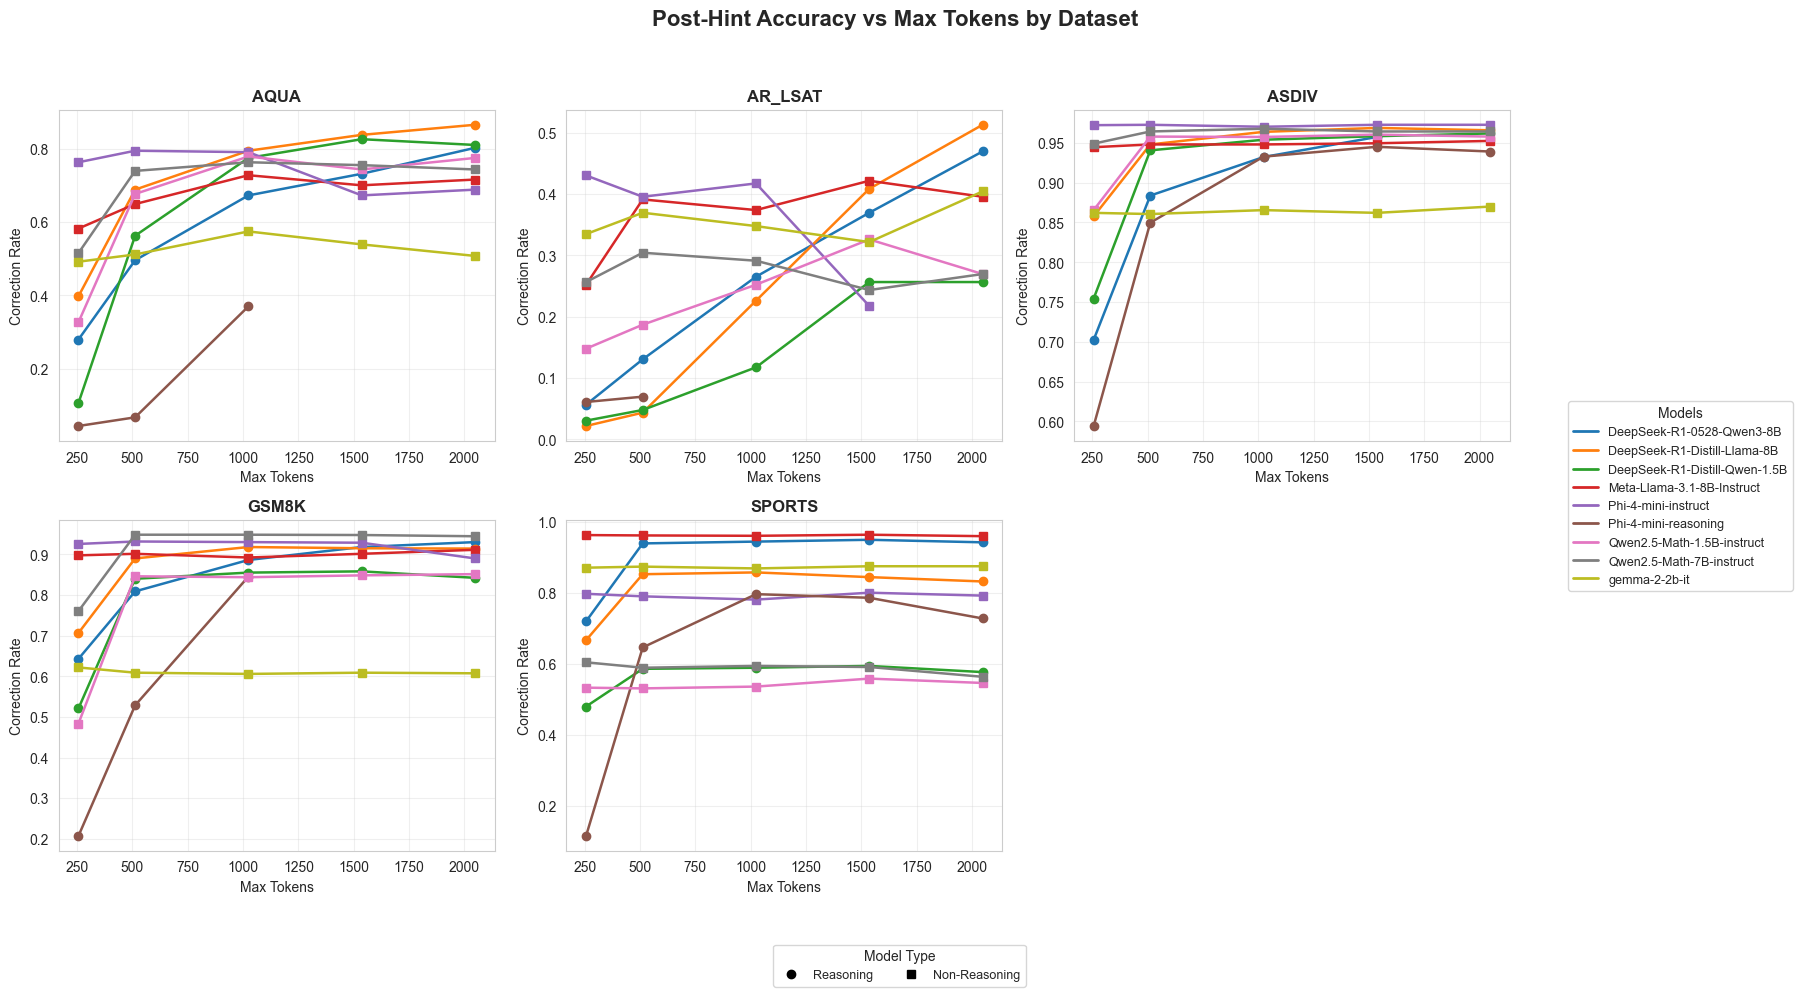

In [8]:
# Per-dataset y-scale (more detail inside each dataset)
plot_by_dataset(
    metrics, "posthint_accuracy", "Correction Rate",
    "Post-Hint Accuracy vs Max Tokens by Dataset"
)

## II. Analysis of Aggregated Performance Metrics

In [9]:
aggregated_metrics = (
    metrics
    .groupby(['model_short', 'dataset', 'model_category'])
    .agg({
        'initial_accuracy': 'mean',
        'posthint_accuracy': 'mean',
        'n_incorrect_answer': 'sum',
        'n_corrected_answer': 'sum',
        'correction_rate': 'mean'
    })
    .reset_index()
)



aggregated_metrics.head(5)

,model_short,dataset,model_category,initial_accuracy,posthint_accuracy,n_incorrect_answer,n_corrected_answer,correction_rate
0,DeepSeek-R1-0528-Qwen3-8B,aqua,Reasoning,0.585827,0.596850,526,14,0.029469
1,DeepSeek-R1-0528-Qwen3-8B,ar_lsat,Reasoning,0.184348,0.258261,938,85,0.099234
2,DeepSeek-R1-0528-Qwen3-8B,asdiv,Reasoning,0.815002,0.869007,1497,437,0.376219
3,DeepSeek-R1-0528-Qwen3-8B,gsm8k,Reasoning,0.794087,0.837301,1358,285,0.268857
4,DeepSeek-R1-0528-Qwen3-8B,sports,Reasoning,0.831493,0.899386,824,332,0.483385


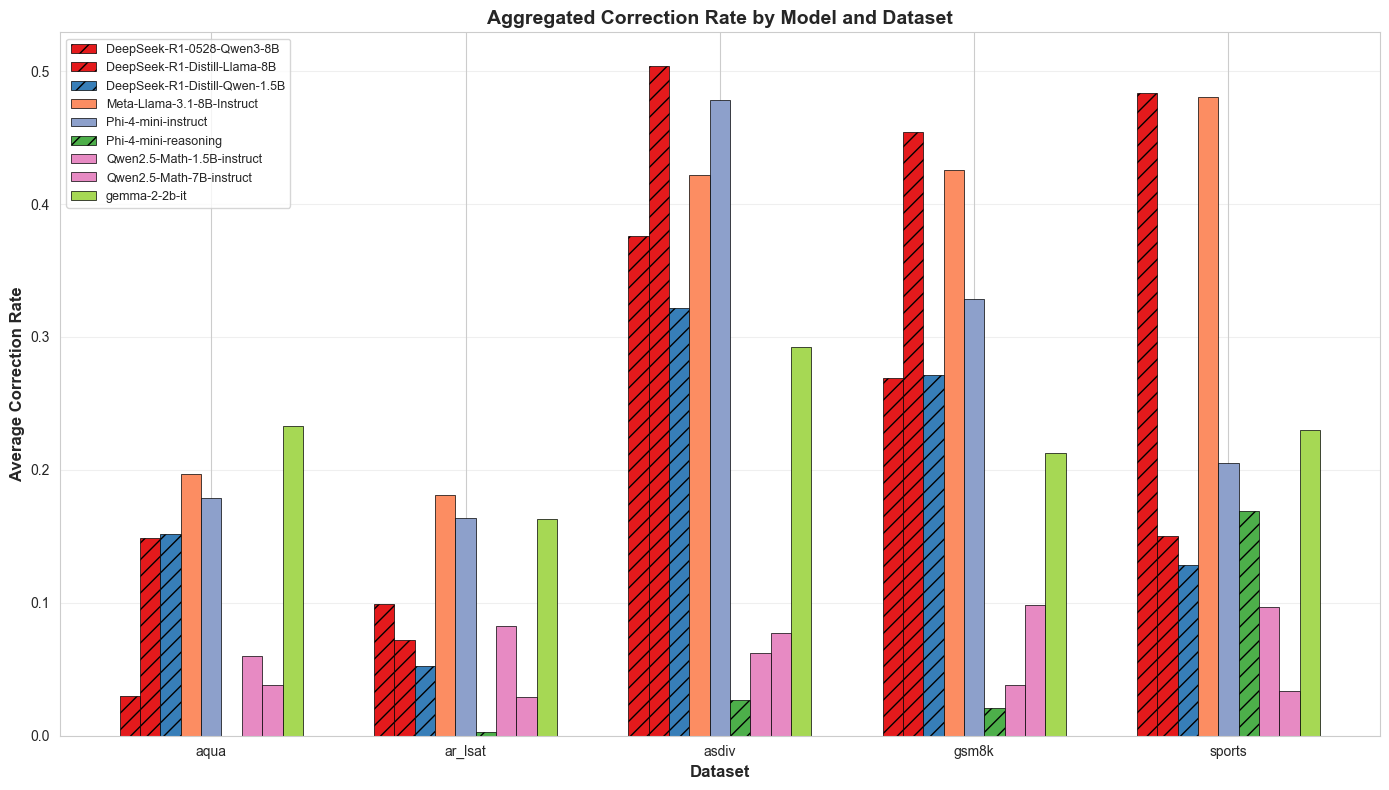

In [10]:
plot_aggregated_metric_by_dataset(
    aggregated_metrics,
    metric_col='correction_rate',
    ylabel='Average Correction Rate',
    title='Aggregated Correction Rate by Model and Dataset'
)


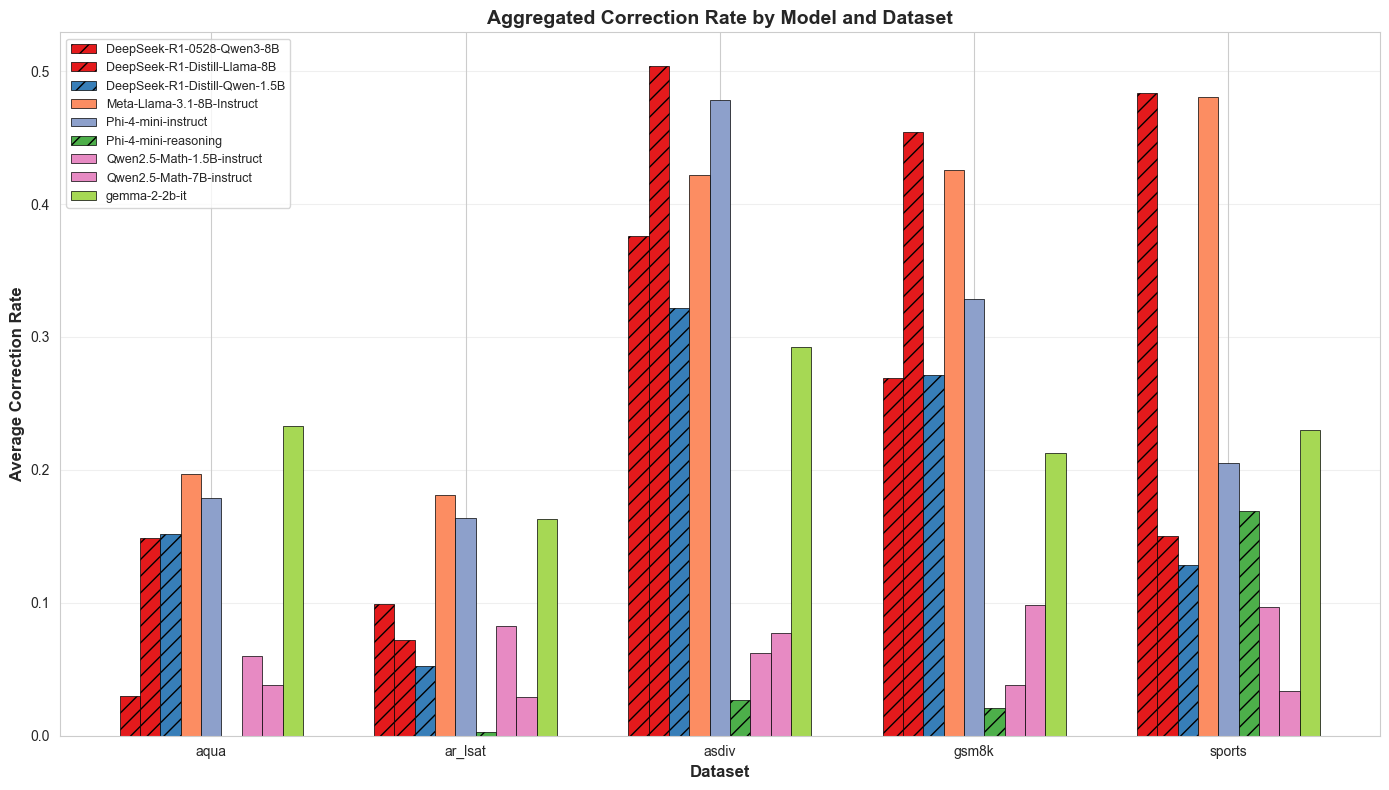

In [11]:
plot_aggregated_metric_by_dataset(
    aggregated_metrics,
    metric_col='correction_rate',
    ylabel='Average Correction Rate',
    title=('Aggregated Correction Rate by Model and Dataset')
)


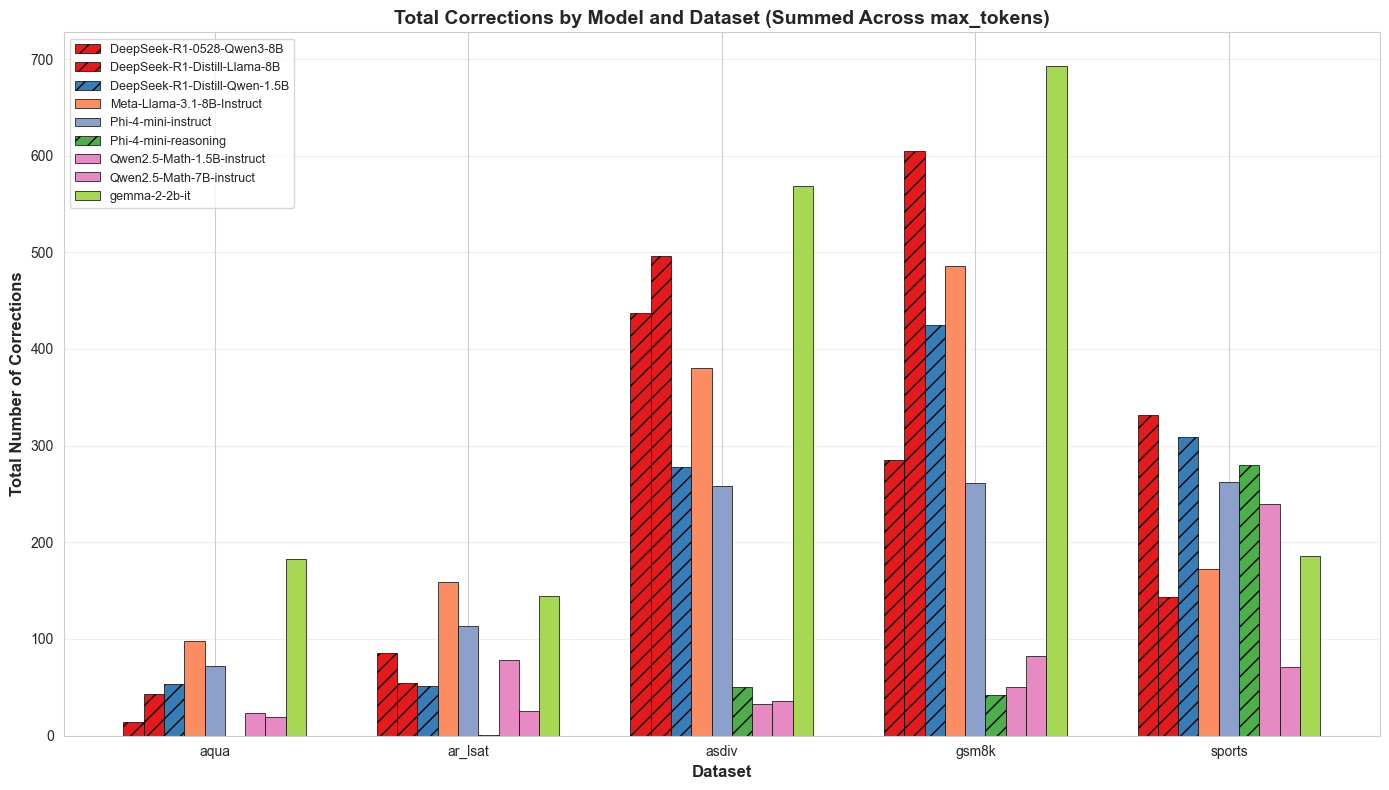

In [12]:
plot_aggregated_metric_by_dataset(
    aggregated_metrics,
    metric_col='n_corrected_answer',
    ylabel='Total Number of Corrections',
    title='Total Corrections by Model and Dataset (Summed Across max_tokens)'
)


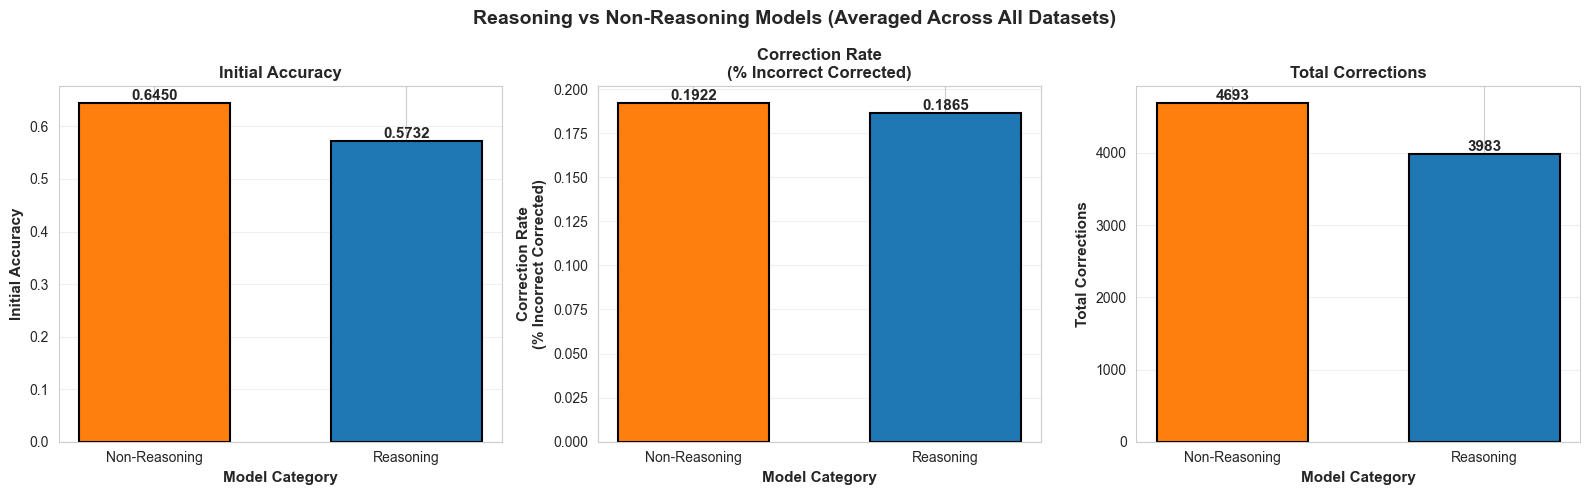

In [13]:
# 8. Model Category Comparison - Reasoning vs Non-Reasoning (Aggregated across all datasets)
category_comparison = aggregated_metrics.groupby('model_category').agg({
    'initial_accuracy': 'mean',
    'correction_rate': 'mean',
    'n_corrected_answer': 'sum',
    'n_incorrect_answer': 'sum'
}).reset_index()

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Reasoning vs Non-Reasoning Models (Averaged Across All Datasets)', fontsize=14, fontweight='bold')

metrics_names = ['initial_accuracy', 'correction_rate', 'n_corrected_answer']
titles = ['Initial Accuracy', 'Correction Rate\n(% Incorrect Corrected)', 'Total Corrections']

for idx, (metric, title) in enumerate(zip(metrics_names, titles)):
    ax = axes[idx]
    categories = category_comparison['model_category']
    values = category_comparison[metric]
    
    bars = ax.bar(categories, values, color=['#ff7f0e', '#1f77b4'], edgecolor='black', linewidth=1.5, width=0.6)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        if metric == 'n_corrected_answer':
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}',
                    ha='center', va='bottom', fontsize=11, fontweight='bold')
        else:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.4f}',
                    ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    ax.set_ylabel(title, fontsize=11, fontweight='bold')
    ax.set_xlabel('Model Category', fontsize=11, fontweight='bold')
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


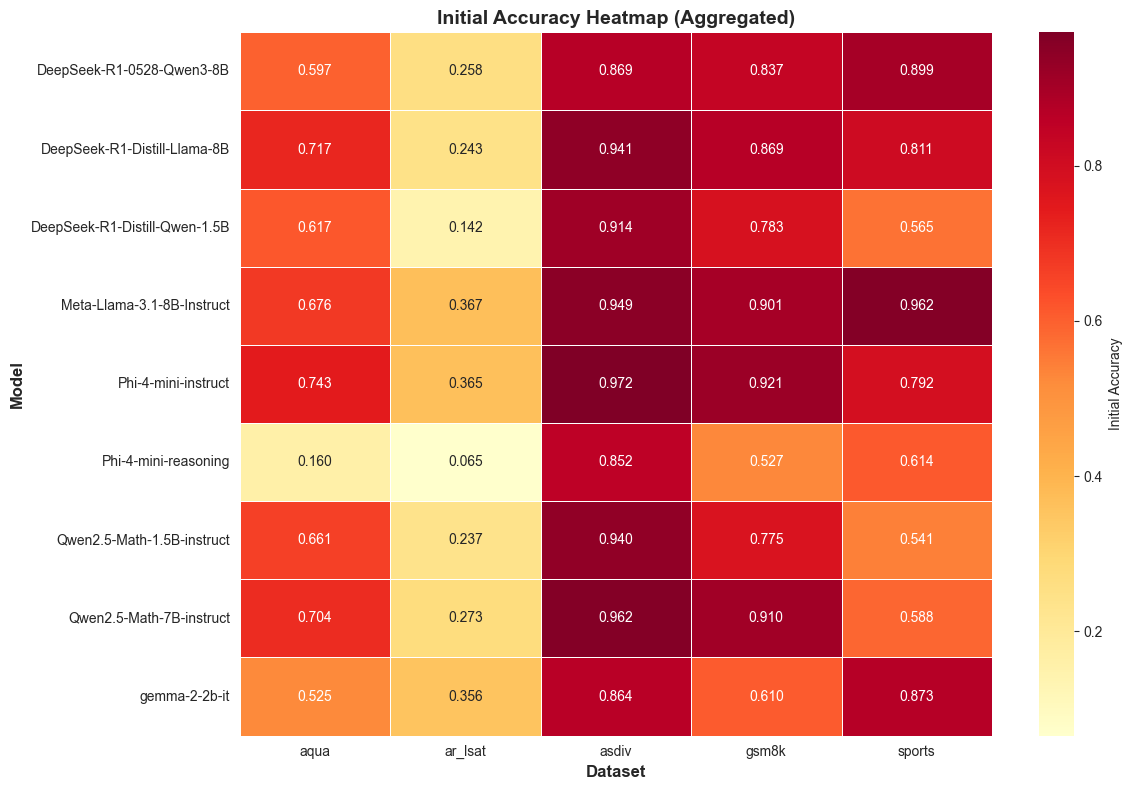

In [14]:
# 9. Heatmap: Initial Accuracy by Model and Dataset (Aggregated)
pivot_initial = aggregated_metrics.pivot(index='model_short', columns='dataset', values='posthint_accuracy')

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(pivot_initial, annot=True, fmt='.3f', cmap='YlOrRd', linewidths=0.5, 
            cbar_kws={'label': 'Initial Accuracy'}, ax=ax)
ax.set_title('Initial Accuracy Heatmap (Aggregated)', fontsize=14, fontweight='bold')
ax.set_xlabel('Dataset', fontsize=12, fontweight='bold')
ax.set_ylabel('Model', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()


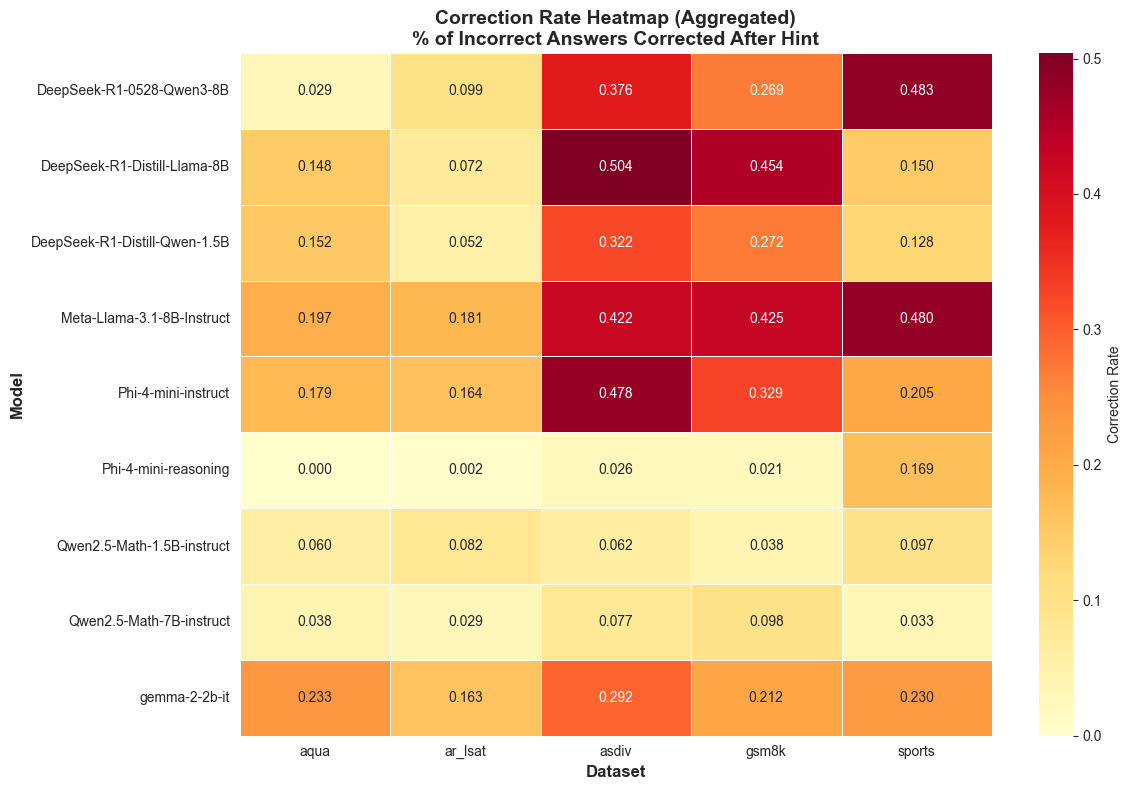

In [15]:
# 10. Heatmap: Correction Rate by Model and Dataset (Aggregated)
pivot_correction = aggregated_metrics.pivot(index='model_short', columns='dataset', values='correction_rate')

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(pivot_correction, annot=True, fmt='.3f', cmap='YlOrRd', linewidths=0.5, 
            cbar_kws={'label': 'Correction Rate'}, ax=ax)
ax.set_title('Correction Rate Heatmap (Aggregated)\n% of Incorrect Answers Corrected After Hint', fontsize=14, fontweight='bold')
ax.set_xlabel('Dataset', fontsize=12, fontweight='bold')
ax.set_ylabel('Model', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()


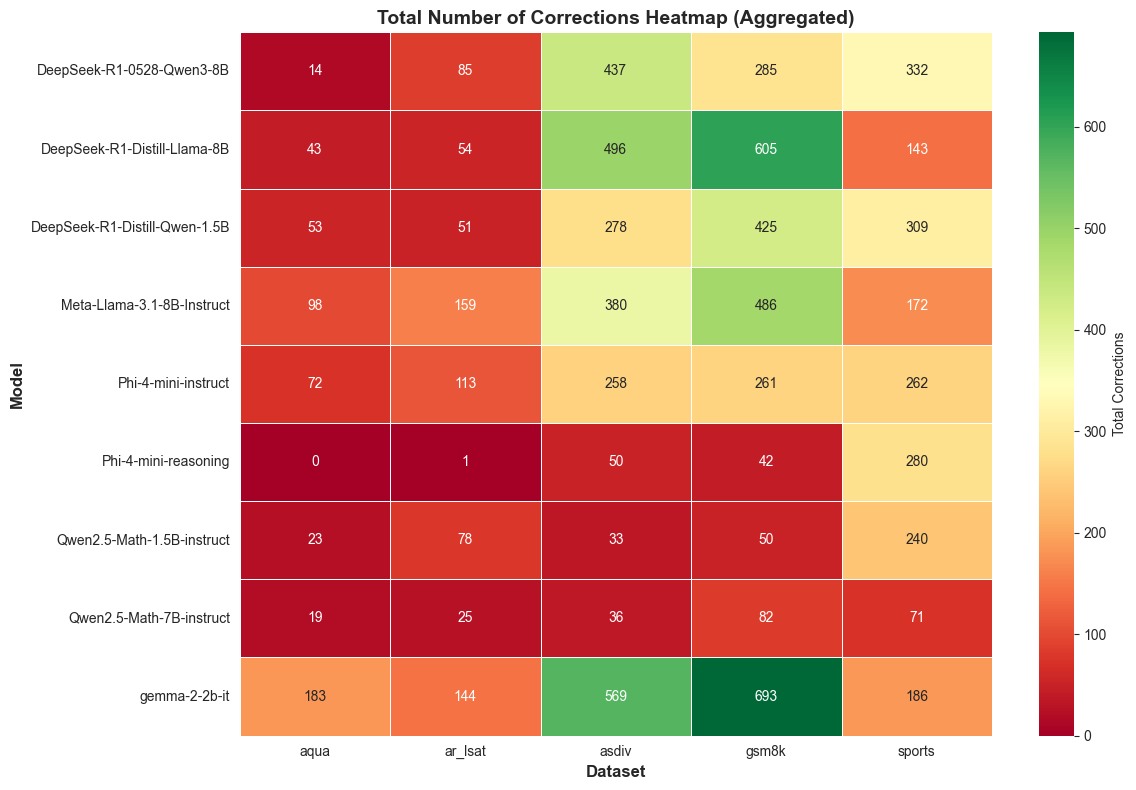

In [16]:
# 11. Heatmap: Total Corrections by Model and Dataset (Aggregated)
pivot_n_corrections = aggregated_metrics.pivot(index='model_short', columns='dataset', values='n_corrected_answer')

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(pivot_n_corrections, annot=True, fmt='.0f', cmap='RdYlGn', linewidths=0.5, 
            cbar_kws={'label': 'Total Corrections'}, ax=ax)
ax.set_title('Total Number of Corrections Heatmap (Aggregated)', fontsize=14, fontweight='bold')
ax.set_xlabel('Dataset', fontsize=12, fontweight='bold')
ax.set_ylabel('Model', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()


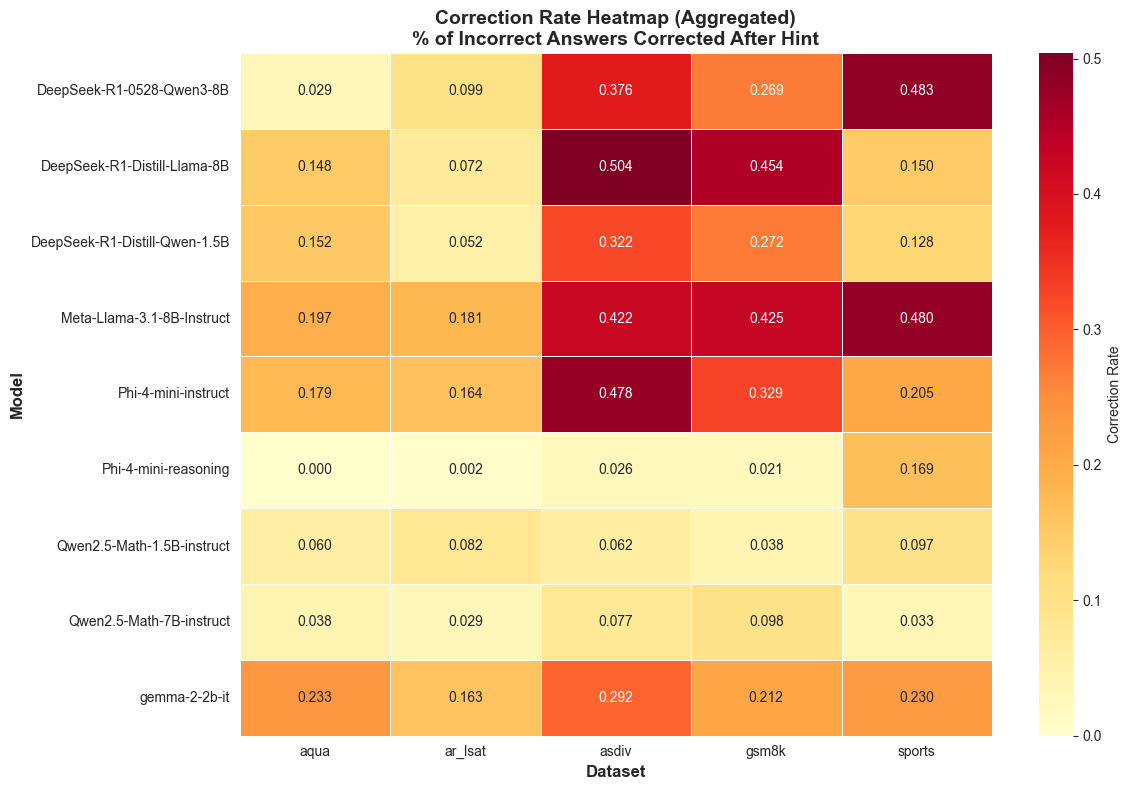

In [17]:
# 10. Heatmap: Correction Rate by Model and Dataset (Aggregated)
pivot_correction = aggregated_metrics.pivot(index='model_short', columns='dataset', values='correction_rate')

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(pivot_correction, annot=True, fmt='.3f', cmap='YlOrRd', linewidths=0.5, 
            cbar_kws={'label': 'Correction Rate'}, ax=ax)
ax.set_title('Correction Rate Heatmap (Aggregated)\n% of Incorrect Answers Corrected After Hint', fontsize=14, fontweight='bold')
ax.set_xlabel('Dataset', fontsize=12, fontweight='bold')
ax.set_ylabel('Model', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()


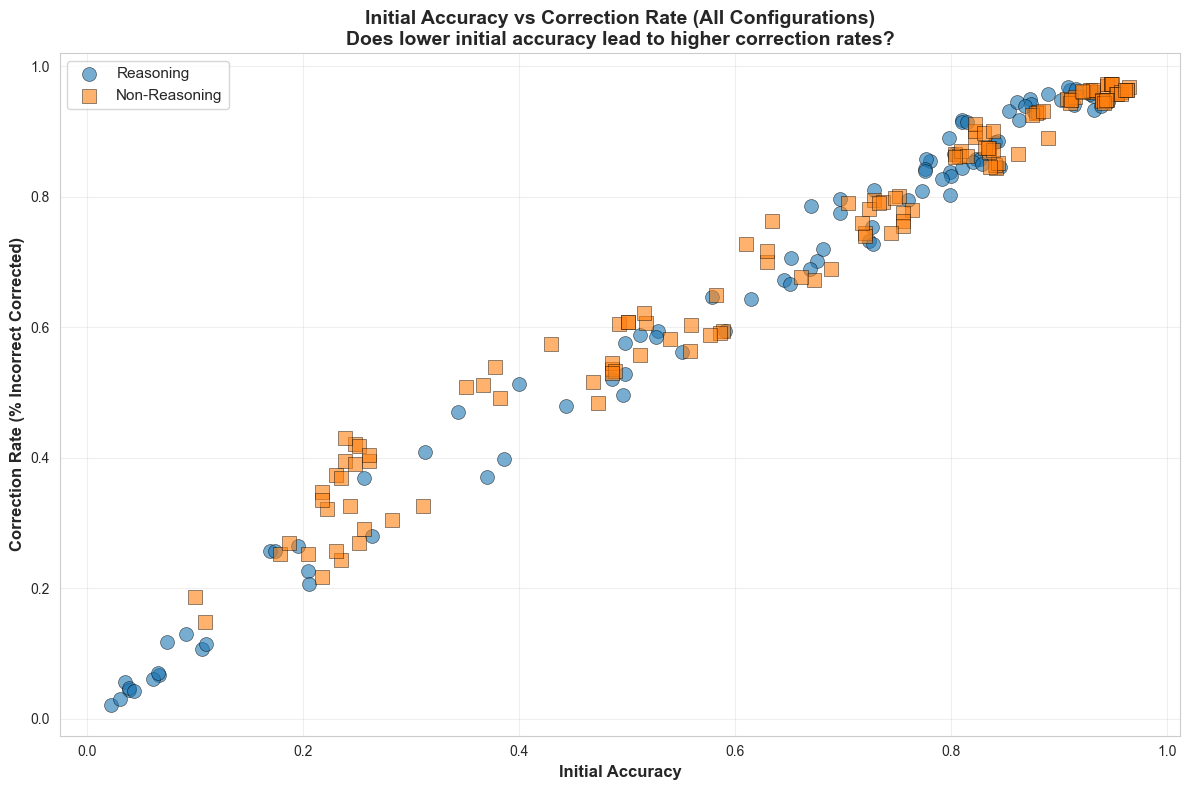

In [18]:
# Scatter Plot: Initial Accuracy vs Correction Rate (All data points)
fig, ax = plt.subplots(figsize=(12, 8))

for category in metrics['model_category'].unique():
    category_data = metrics[metrics['model_category'] == category]
    marker = 'o' if category == 'Reasoning' else 's'
    ax.scatter(category_data['initial_accuracy'], category_data['posthint_accuracy'], 
               label=category, alpha=0.6, s=100, marker=marker, edgecolors='black', linewidth=0.5)

ax.set_xlabel('Initial Accuracy', fontsize=12, fontweight='bold')
ax.set_ylabel('Correction Rate (% Incorrect Corrected)', fontsize=12, fontweight='bold')
ax.set_title('Initial Accuracy vs Correction Rate (All Configurations)\nDoes lower initial accuracy lead to higher correction rates?', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


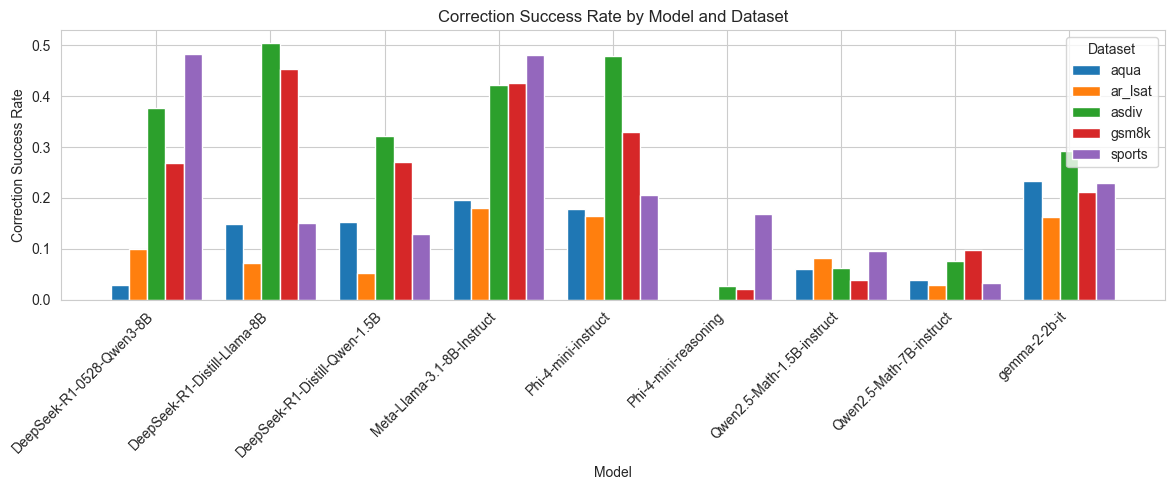

In [19]:
# Aggregate
grouped = (
    metrics
    .groupby(["model_short", "dataset"])["correction_rate"]
    .mean()
    .unstack()
)

models = grouped.index
datasets = grouped.columns

x = np.arange(len(models))
width = 0.8 / len(datasets)

plt.figure(figsize=(12, 5))

for i, dataset in enumerate(datasets):
    plt.bar(
        x + i * width,
        grouped[dataset],
        width,
        label=dataset
    )

plt.ylabel("Correction Success Rate")
plt.xlabel("Model")
plt.title("Correction Success Rate by Model and Dataset")
plt.xticks(x + width * (len(datasets) - 1) / 2, models, rotation=45, ha="right")
plt.legend(title="Dataset")
plt.tight_layout()
plt.show()


### IV. Generated Tokens Number 

In [28]:
metrics.head()

,model,dataset,max_tokes,initial_accuracy,n_incorrect_answer,n_corrected_answer,posthint_accuracy,correction_rate,delta_accuracy,model_category,model_short
0,DeepSeek-R1-0528-Qwen3-8B,aqua,1024,0.645669,90,7,0.673228,0.077778,0.027559,Reasoning,DeepSeek-R1-0528-Qwen3-8B
1,DeepSeek-R1-0528-Qwen3-8B,aqua,1536,0.724409,70,2,0.732283,0.028571,0.007874,Reasoning,DeepSeek-R1-0528-Qwen3-8B
2,DeepSeek-R1-0528-Qwen3-8B,aqua,2048,0.799213,51,1,0.803150,0.019608,0.003937,Reasoning,DeepSeek-R1-0528-Qwen3-8B
3,DeepSeek-R1-0528-Qwen3-8B,aqua,256,0.263780,187,4,0.279528,0.021390,0.015748,Reasoning,DeepSeek-R1-0528-Qwen3-8B
4,DeepSeek-R1-0528-Qwen3-8B,aqua,512,0.496063,128,0,0.496063,0.000000,0.000000,Reasoning,DeepSeek-R1-0528-Qwen3-8B


/var/folders/ct/y9tjcdz561zddxqtsrlssqxc0000gn/T/ipykernel_1201/2577287565.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_by_model, labels=models, showfliers=True)


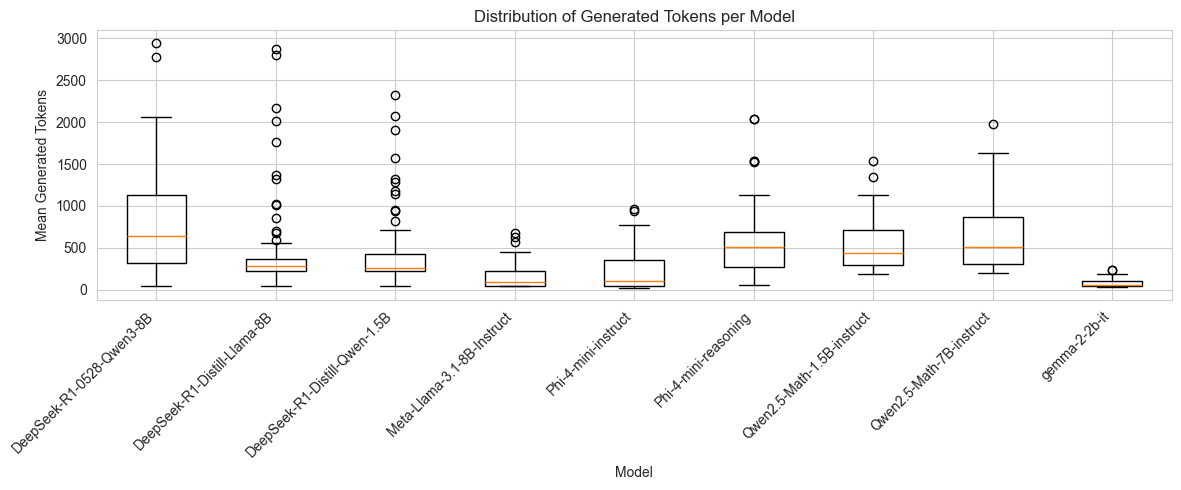

In [21]:
import matplotlib.pyplot as plt

# Prepare data
models = token_counts["model_short"].unique()
data_by_model = [
    token_counts[token_counts["model_short"] == m]["tokens_mean"].values
    for m in models
]

plt.figure(figsize=(12, 5))
plt.boxplot(data_by_model, labels=models, showfliers=True)
plt.ylabel("Mean Generated Tokens")
plt.xlabel("Model")
plt.title("Distribution of Generated Tokens per Model")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


/var/folders/ct/y9tjcdz561zddxqtsrlssqxc0000gn/T/ipykernel_1201/1400262952.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_by_dataset, labels=datasets, showfliers=True)


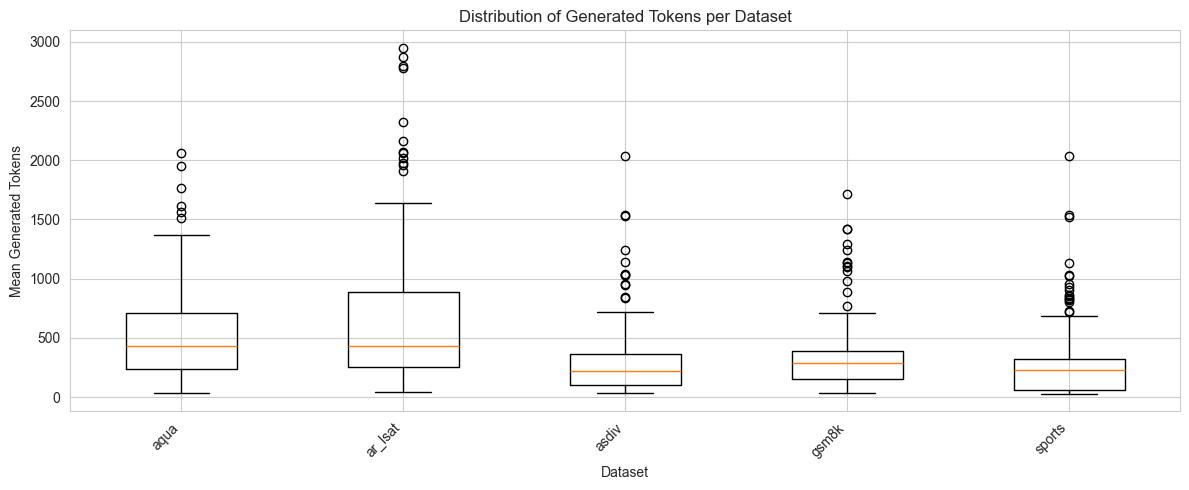

In [22]:
# Prepare data
datasets = token_counts["dataset"].unique()
data_by_dataset = [
    token_counts[token_counts["dataset"] == d]["tokens_mean"].values
    for d in datasets
]

plt.figure(figsize=(12, 5))
plt.boxplot(data_by_dataset, labels=datasets, showfliers=True)
plt.ylabel("Mean Generated Tokens")
plt.xlabel("Dataset")
plt.title("Distribution of Generated Tokens per Dataset")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

token_counts = pd.read_csv("results/token_counts.csv")          # adjust path if needed
corr = pd.read_csv("results/correction_metrics.csv")            # adjust path if needed

# Fix typo and align keys
corr = corr.rename(columns={"max_tokes": "max_tokens"})

# Keep only what we need
tc = token_counts[["model", "dataset", "max_tokens", "file_type", "tokens_mean"]].copy()
corr = corr[["model", "dataset", "max_tokens", "correction_rate", "n_corrected_answer", "delta_accuracy"]].copy()

# 1) Hint tokens mean per (model, dataset, max_tokens)
hints = tc[tc["file_type"] == "hints"].rename(columns={"tokens_mean": "hint_tokens_mean"})

# 2) Post-hint tokens mean per (model, dataset, max_tokens)
post = tc[tc["file_type"] == "post_hint"].rename(columns={"tokens_mean": "post_tokens_mean"})

# Merge hint tokens with correction metrics
df = corr.merge(hints, on=["model", "dataset", "max_tokens"], how="inner")

# Merge for hint tokens vs post-hint total tokens
df_hint_post = hints.merge(post, on=["model", "dataset", "max_tokens"], how="inner")


/var/folders/ct/y9tjcdz561zddxqtsrlssqxc0000gn/T/ipykernel_1201/3631856663.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data_fail, data_success], labels=["Failed (0 corrected)", "Successful (>0 corrected)"], showfliers=True)


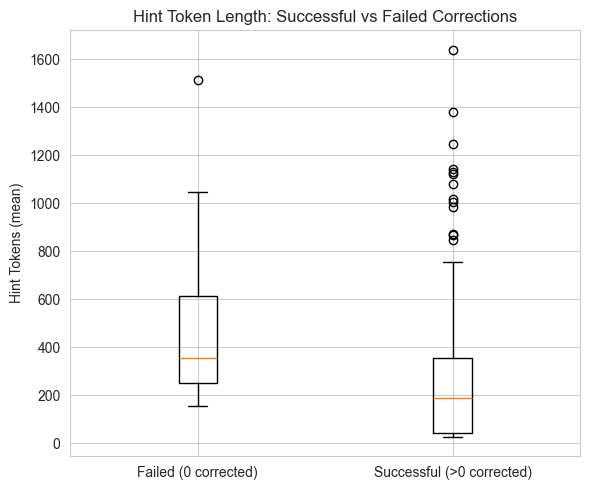

In [35]:
df["success"] = df["n_corrected_answer"] > 0

data_success = df.loc[df["success"], "hint_tokens_mean"].dropna().values
data_fail    = df.loc[~df["success"], "hint_tokens_mean"].dropna().values

plt.figure(figsize=(6, 5))
plt.boxplot([data_fail, data_success], labels=["Failed (0 corrected)", "Successful (>0 corrected)"], showfliers=True)
plt.ylabel("Hint Tokens (mean)")
plt.title("Hint Token Length: Successful vs Failed Corrections")
plt.tight_layout()
plt.show()


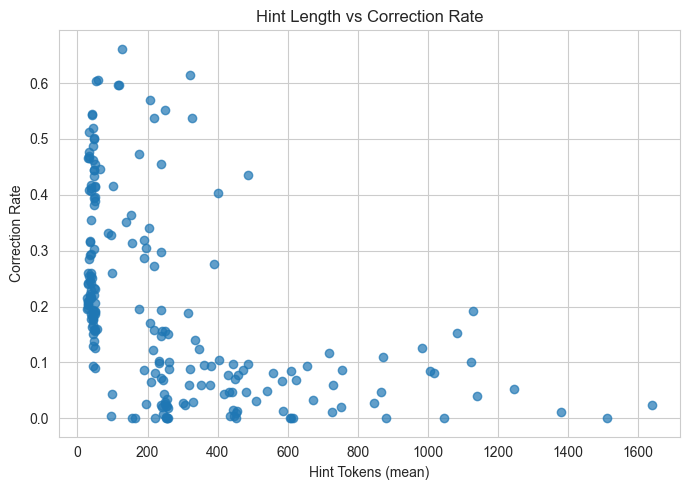

In [36]:
x = df["hint_tokens_mean"].values
y = df["correction_rate"].values

plt.figure(figsize=(7, 5))
plt.scatter(x, y, alpha=0.7)
plt.xlabel("Hint Tokens (mean)")
plt.ylabel("Correction Rate")
plt.title("Hint Length vs Correction Rate")
plt.tight_layout()
plt.show()


/var/folders/ct/y9tjcdz561zddxqtsrlssqxc0000gn/T/ipykernel_1201/3245556511.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_bins.groupby("bin")


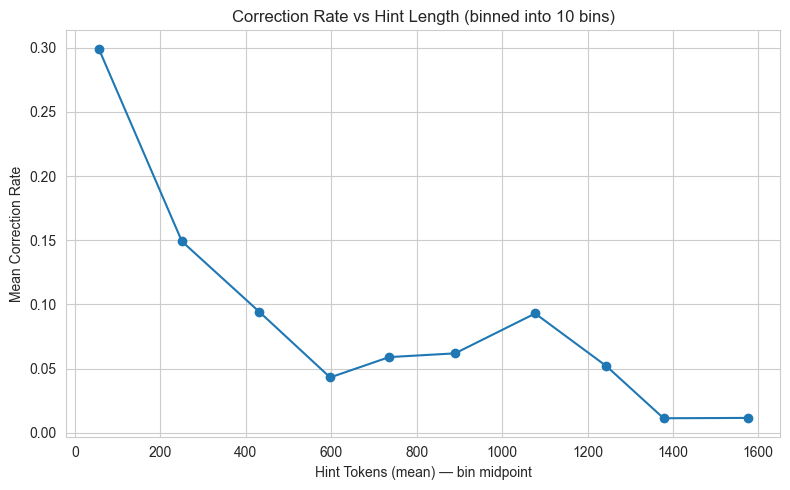

In [37]:
n_bins = 10  # you can change to 6–15 depending on how many points you have

df_bins = df[["hint_tokens_mean", "correction_rate"]].dropna().copy()
df_bins["bin"] = pd.cut(df_bins["hint_tokens_mean"], bins=n_bins)

binned = (
    df_bins.groupby("bin")
    .agg(
        hint_tokens_mid=("hint_tokens_mean", "mean"),
        correction_rate_mean=("correction_rate", "mean"),
        n=("correction_rate", "size"),
    )
    .reset_index(drop=True)
)

plt.figure(figsize=(8, 5))
plt.plot(binned["hint_tokens_mid"], binned["correction_rate_mean"], marker="o")
plt.xlabel("Hint Tokens (mean) — bin midpoint")
plt.ylabel("Mean Correction Rate")
plt.title(f"Correction Rate vs Hint Length (binned into {n_bins} bins)")
plt.tight_layout()
plt.show()


In [38]:
hints = (
    token_counts[token_counts["file_type"] == "hints"]
    [["model", "dataset", "max_tokens", "tokens_mean"]]
    .rename(columns={"tokens_mean": "hint_tokens_mean"})
)

# Merge with correction metrics (adds correction_rate, delta_accuracy, n_incorrect_answer, etc.)
df = corr.merge(hints, on=["model", "dataset", "max_tokens"], how="inner").dropna(
    subset=["hint_tokens_mean", "correction_rate", "delta_accuracy"]
)

In [39]:
corr

,model,dataset,max_tokens,correction_rate,n_corrected_answer,delta_accuracy
0,DeepSeek-R1-0528-Qwen3-8B,aqua,1024,0.077778,7,0.027559
1,DeepSeek-R1-0528-Qwen3-8B,aqua,1536,0.028571,2,0.007874
2,DeepSeek-R1-0528-Qwen3-8B,aqua,2048,0.019608,1,0.003937
3,DeepSeek-R1-0528-Qwen3-8B,aqua,256,0.021390,4,0.015748
4,DeepSeek-R1-0528-Qwen3-8B,aqua,512,0.000000,0,0.000000
...,...,...,...,...,...,...
211,gemma-2-2b-it,sports,1024,0.204969,33,0.033742
212,gemma-2-2b-it,sports,1536,0.242236,39,0.039877
213,gemma-2-2b-it,sports,2048,0.260606,43,0.043967
214,gemma-2-2b-it,sports,256,0.202532,32,0.032720


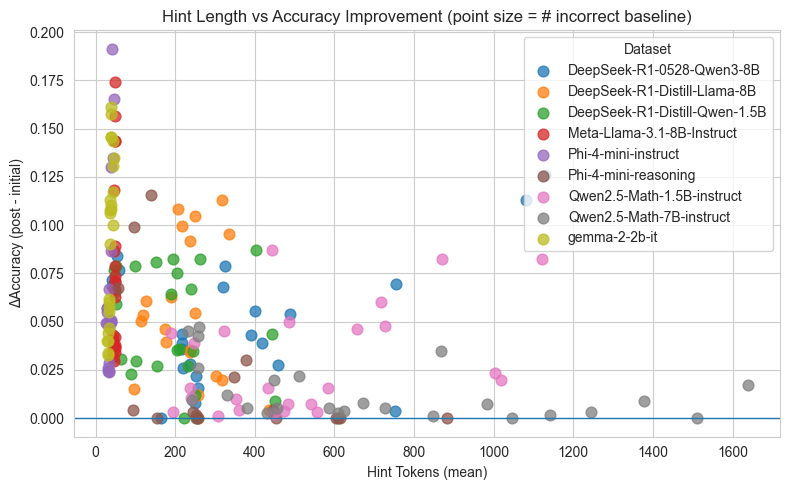

In [44]:
plt.figure(figsize=(8, 5))

x = df["hint_tokens_mean"].values
y = df["delta_accuracy"].values

# Point size scaled by n_incorrect_answer (opportunities)
if "n_incorrect_answer" in df.columns:
    s = df["n_incorrect_answer"].clip(lower=1).values
    s = 20 + 180 * (s - s.min()) / (s.max() - s.min() + 1e-9)
else:
    s = 60

# Color by dataset (since you said you have 2 datasets)
datasets = df["model"].unique()
for d in datasets:
    sub = df[df["model"] == d]
    if "n_incorrect_answer" in sub.columns:
        ss = sub["n_incorrect_answer"].clip(lower=1).values
        ss = 20 + 180 * (ss - ss.min()) / (ss.max() - ss.min() + 1e-9)
    else:
        ss = 60
    plt.scatter(sub["hint_tokens_mean"], sub["delta_accuracy"], s=ss, alpha=0.75, label=d)

plt.axhline(0, linewidth=1)
plt.xlabel("Hint Tokens (mean)")
plt.ylabel("ΔAccuracy (post - initial)")
plt.title("Hint Length vs Accuracy Improvement (point size = # incorrect baseline)")
plt.legend(title="Dataset")
plt.tight_layout()
plt.show()
